# 1. Importing Libraries

In [1]:
#!pip install qiskit
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi
import warnings
warnings.filterwarnings('ignore')

# 2. Loading Dataset

In [2]:
data = pd.read_csv('kmeans_data.csv',
    usecols=['Feature 1', 'Feature 2', 'Class'])

In [3]:
data

,Feature 1,Feature 2,Class
0,-0.646,0.763,Green
1,-0.610,0.617,Green
2,-0.596,0.915,Green
3,-0.565,0.927,Green
4,-0.542,0.631,Green
...,...,...,...
70,0.719,0.307,Black
71,0.724,0.113,Black
72,0.739,0.432,Black
73,0.784,0.257,Black


Our goal is to estimate the distance of target point from all centroids
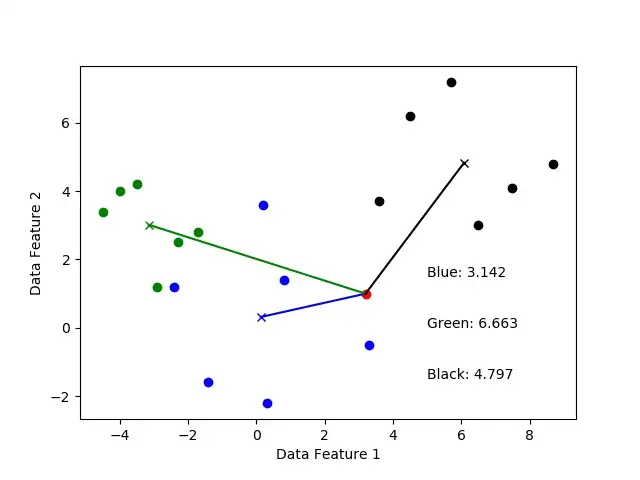

# 3. Filter data/features based on colour

In [4]:
# Create binary variables to filter data
isGreen = data['Class'] == 'Green'
isBlue = data['Class'] == 'Blue'
isBlack = data['Class'] == 'Black'

In [5]:
# Filter data
# Drop if colour is False
greenData = data[isGreen].drop(['Class'], axis=1)
blueData = data[isBlue].drop(['Class'], axis=1)
blackData = data[isBlack].drop(['Class'], axis=1)

In [6]:
greenData

,Feature 1,Feature 2
0,-0.646,0.763
1,-0.610,0.617
2,-0.596,0.915
3,-0.565,0.927
4,-0.542,0.631
5,-0.542,0.941
6,-0.535,0.848
7,-0.527,0.615
8,-0.431,0.505
9,-0.430,0.426


# 4. Plotting Centroids and Target Point

### >> Target Point

In [7]:
# This is the point we need to classify
y_p = 0.141
x_p = -0.161

### >> Centroids

See Readme File to undestand how the centroid's co-ordinates are calculated

In [8]:
# Finding the x-coords of the centroids
xgc = sum(greenData['Feature 1']) / len(greenData['Feature 1'])
xbc = sum(blueData['Feature 1']) / len(blueData['Feature 1'])
xkc = sum(blackData['Feature 1']) / len(blackData['Feature 1'])

# Finding the y-coords of the centroids
ygc = sum(greenData['Feature 2']) / len(greenData['Feature 2'])
ybc = sum(blueData['Feature 2']) / len(blueData['Feature 2'])
ykc = sum(blackData['Feature 2']) / len(blackData['Feature 2'])

### >> Plotting the points

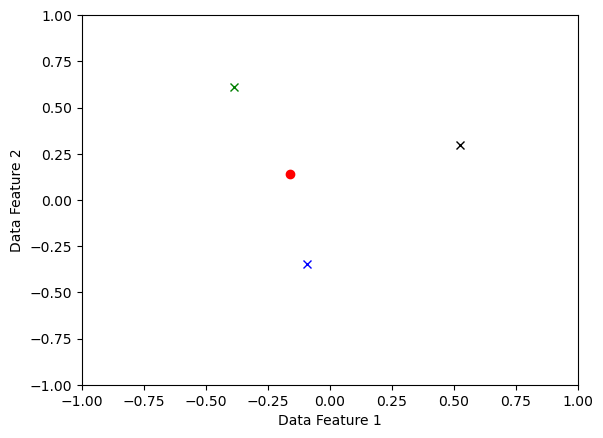

In [9]:
fig, ax = plt.subplots()
ax.set(xlabel='Data Feature 1', ylabel='Data Feature 2')

# Plotting the centroids
plt.plot(xgc, ygc, 'gx')
plt.plot(xbc, ybc, 'bx')
plt.plot(xkc, ykc, 'kx')

# Plotting the new data point
plt.plot(x_p, y_p, 'ro')

# Setting the axis ranges
plt.axis([-1, 1, -1, 1])

plt.show()

We need to compare the distances from the red dot to each of the centroids — so we have to encode the coordinates of the centroids and the red dot into our qubits. To do this we use the rules we came up with (Refer readme file):

# 5. Encoding Target Point and Centroids into qubits

In [10]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

### To encode we perform the following steps:
1. We take a zero initialized qubit and apply a Hadamard gate to move it from Z basis to X-axis.


2. We set `Φ (0<= Φ <= π)` depending on value of data point corresponding to feature 1.

   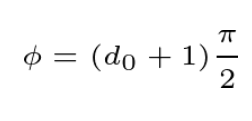
   
   where d_0 stands for data values of feature 1.
   
   
3. We set `θ (0<= θ <= π)` depending on value of data point corresponding to feature 2.

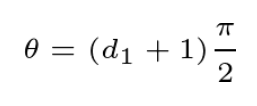

    where d_1 stands for data values of feature 1.

### >> Calculating Theta and Phi

In [11]:
# Calculating theta and phi values
phi_list = [((x + 1) * pi / 2) for x in [x_p, xgc, xbc, xkc]]
theta_list = [((x + 1) * pi / 2) for x in [y_p, ygc, ybc, ykc]]

### >> Creating a Quantum Circuit

In [12]:
# Create a 3 qubit QuantumRegister - two for the vectors, and 
# one for the ancillary qubit
qreg = QuantumRegister(3, 'qreg')

# Create a one bit ClassicalRegister to hold the result
# of the measurements
creg = ClassicalRegister(1, 'creg')

qc = QuantumCircuit(qreg, creg, name='qc')

We can use the U3 gate provided by qiskit to implement the rotations we need to perform to encode our data points.

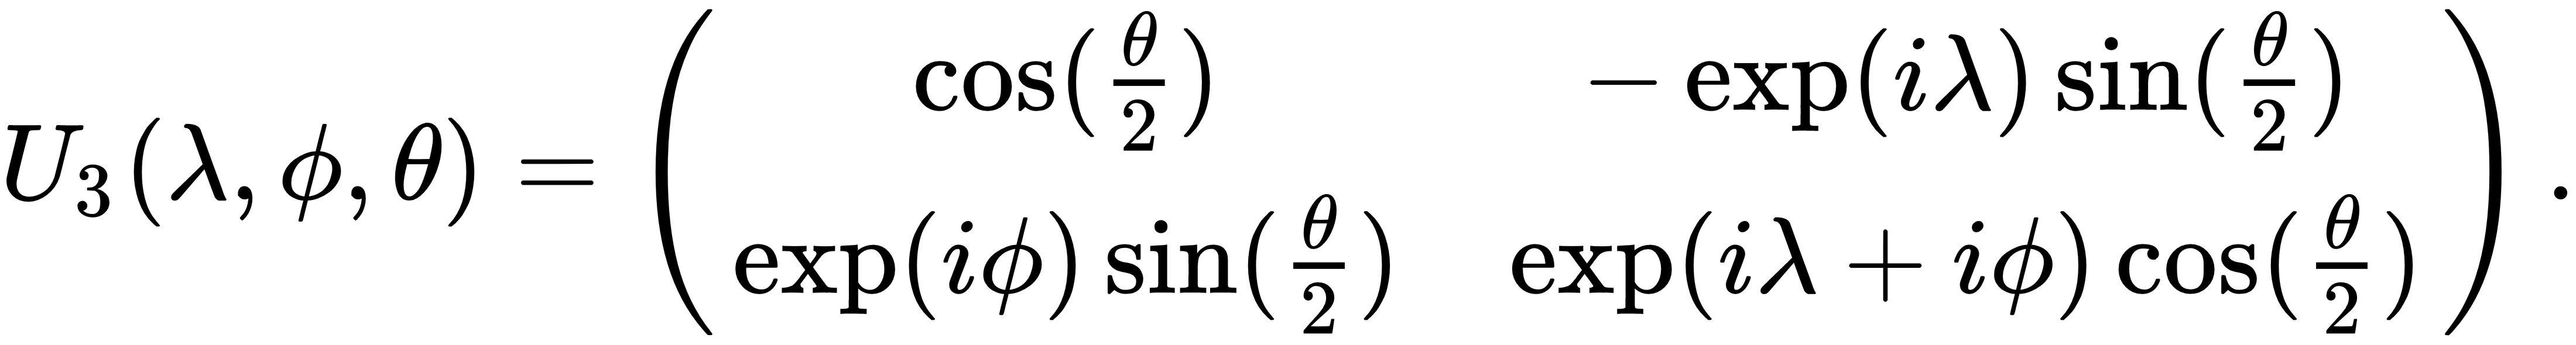

`qc.u3(theta, phi, lambda, qreg[i])`

This instruction would cause the qubit to move θ radians away from the positive z-axis, and Φ radians away from the positive x-axis,

# 6. Calculating Distance using Quantum Estimator

## >> Quantum Simulator

In [13]:
# Get backend using the Aer provider
backend_sim = Aer.get_backend('qasm_simulator')

# Create list to hold the results
results_list_sim = []

# Estimating distances from the new point to the centroids
for i in range(1, 4):
    # Apply a Hadamard to the ancillary
    qc.h(qreg[2]) #ancillary is last

    # Encode new point and centroid from coordinate to bloch sphere
    qc.u3(theta_list[0], phi_list[0], 0, qreg[0]) #this is our red point        
    qc.u3(theta_list[i], phi_list[i], 0, qreg[1]) # this is all centroids

    # Perform controlled swap
    qc.cswap(qreg[2], qreg[0], qreg[1])
    # Apply second Hadamard to ancillary
    qc.h(qreg[2])

    # Measure ancillary
    qc.measure(qreg[2], creg[0])

    # Reset qubits
    qc.reset(qreg) # so that we can resuse it again, as it consumes less memory and space.

    # Register and execute job
    job_sim = execute(qc, backend=backend_sim, shots=1024)
    result_sim = job_sim.result().get_counts(qc) # count on |1>
    results_list_sim.append(result_sim['1']) # distance of each centroid from red
    
print(results_list_sim)

[85, 73, 131]


In [14]:
result_sim

{'1': 131, '0': 893}

## >> Real Quantum Computer

In [18]:
#IBMQ.save_account('API Token')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_real = provider.get_backend('ibmq_belem')

# Create list to hold the results
results_list_real = []

# Estimating distances from the new point to the centroids
for i in range(1, 4):
    # Apply a Hadamard to the ancillary
    qc.h(qreg[2]) #ancillary is last

    # Encode new point and centroid from coordinate to bloch sphere
    qc.u3(theta_list[0], phi_list[0], 0, qreg[0]) #this is our red point        
    qc.u3(theta_list[i], phi_list[i], 0, qreg[1]) # this is all centroids

    # Perform controlled swap
    qc.cswap(qreg[2], qreg[0], qreg[1])
    # Apply second Hadamard to ancillary
    qc.h(qreg[2])

    # Measure ancillary
    qc.measure(qreg[2], creg[0])

    # Reset qubits
    qc.reset(qreg) # so that we can resuse it again, as it consumes less memory and space.

    # Register and execute job
    job_real = execute(qc, backend=backend_real, shots=1024)
    result_real = job_real.result().get_counts(qc) # count on |1>
    results_list_real.append(result_real['1']) # distance of each centroid from red
    
print(results_list_real)

ibmqfactory.load_account:WARNING:2022-12-18 13:36:12,237: Credentials are already in use. The existing account in the session will be replaced.


[212, 204, 260]


# 7. Comparing results

Now we can check which class the new data point belongs to. Let’s also print the Euclidean distances to get an idea of what the differences between distances to each centroids are:

In [19]:
#!pip install simple_colors
from simple_colors import *

In [20]:
# Create a list to hold the possible classes
class_list = ['Green', 'Blue', 'Black']

# Find out which class the new data point belongs to 

# according to our distance estimation algorithm
quantum_sim = class_list[results_list_sim.index(min(results_list_sim))]
quantum_real = class_list[results_list_real.index(min(results_list_real))]

# according to classical euclidean distance calculation
distances_list = [((x_p - i[0])**2 + (y_p - i[1])**2)**0.5 for i in [(xgc, ygc), (xbc, ybc), (xkc, ykc)]]
classical_class = class_list[distances_list.index(min(distances_list))]

# Print results
print(black("Using Quantum Simulator", 'bold'), '\n')
print('Quantum Estimator distances: ', results_list_sim)
print('The new data point belongs to the {} Class'.format(quantum_sim), '\n')

print(black("Using Real Quantum Computer",'bold'), '\n')
print('Quantum Estimator distances: ', results_list_real)
print('The new data point belongs to the {} Class'.format(quantum_real), '\n')

print(black("With Classical Approach",'bold'), '\n')
print('Euclidean Distances: ', distances_list)
print('The new data point belongs to the {} Class'.format(classical_class), '\n')

Using Quantum Simulator 

Quantum Estimator distances:  [85, 73, 131]
The new data point belongs to the Blue Class 

Using Real Quantum Computer 

Quantum Estimator distances:  [212, 204, 260]
The new data point belongs to the Blue Class 

With Classical Approach 

Euclidean Distances:  [0.520285324797846, 0.4905204028376394, 0.7014755294377704]
The new data point belongs to the Blue Class 



We were able to correctly classify our point into the Blue Class in both cases (simulator and real device).

**Our distance estimator model was correct and successfully built a quantum distance estimator to use with the k — means clustering algorithm.**